### Implement Softmax Regression From Scratch

In [1]:
%matplotlib inline
import d2lzh as d2l
import utils
from mxnet import autograd, nd

#### Read Datasets

In [2]:
batch_size = 256
train_iter, test_iter = utils.load_data_fashion_mnist(batch_size) # see details in utils.py and 06

In [3]:
num_inputs = 784 # 28 * 28. each pixel is a feature.
# transform a 28 * 28 matrix to a 1 * 784 vector, which may lead to some question because we lose the
# vertical information.
num_outputs = 10 # there are 10 catagory

# initialize weight and bias
W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs)) # W is in R784*10
b = nd.zeros(num_outputs) # initialize the bias as zero. b is in R10

# attach gradient
W.attach_grad()
b.attach_grad()

In [8]:
# for X, y in train_iter:
#     utils.show_fashion_mnist(X, utils.get_fashion_mnist_labels(y.asnumpy())) # numpy is better maybe,
#     break


[9 3 5 8 3 2 9 8 1 9 5 9 4 4 7 2 3 4 6 6 0 5 6 6 6 8 3 4 9 6 4 8 2 7 8 8 9
 3 5 8 7 5 5 8 8 6 4 9 3 5 1 4 9 8 1 5 9 3 6 7 3 2 2 0 8 1 9 3 7 8 4 2 9 2
 2 4 8 2 8 2 7 7 8 6 3 5 9 8 5 4 0 5 5 7 3 5 1 0 4 9 2 2 0 0 6 7 4 1 1 1 2
 3 3 6 8 6 6 6 2 3 6 6 0 9 8 4 2 7 5 5 7 4 7 7 3 5 2 9 6 6 7 2 1 6 2 8 9 5
 0 4 7 2 5 8 2 9 8 9 4 6 3 2 1 4 8 9 1 1 5 3 0 4 7 8 4 3 7 9 6 9 2 2 3 3 5
 6 9 5 3 1 3 5 2 2 2 8 7 8 7 4 0 2 9 1 5 5 2 1 0 2 4 3 0 2 9 4 7 9 3 0 0 9
 5 3 0 5 5 9 2 7 0 5 3 9 5 4 3 4 6 2 6 8 1 4 6 6 9 2 5 5 9 3 6 1 8 9]
<NDArray 256 @cpu(0)>


#### Implement Softmax Operation

In [4]:
X = nd.array([[1, 2, 3], [4, 5, 6]])
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True) # sum in column and sum in row

(
 [[5. 7. 9.]]
 <NDArray 1x3 @cpu(0)>, 
 [[ 6.]
  [15.]]
 <NDArray 2x1 @cpu(0)>)

In [5]:
def softmax(X): # X is R784(features)*256(batch size)
    X_exp = X.exp() # each element x in matrix X will be converted to exp(x)
    partition = X_exp.sum(axis=1, keepdims=True) # sum in row
    return X_exp / partition # boradcast => each element divided by the sum of its row!

In [6]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1) # make every number positive between 0~1 and the sum of each row is 1

(
 [[0.6264712  0.126293   0.01826552 0.10885343 0.12011679]
  [0.25569436 0.2917251  0.07546549 0.3024068  0.07470828]]
 <NDArray 2x5 @cpu(0)>, 
 [0.99999994 1.        ]
 <NDArray 2 @cpu(0)>)

#### Define Model
$$O = XW + b$$

In [7]:
def net(X): # X in R256*1*28*28, W in R784*10, b in R10, X -> reshape 256*784, XW ->256*10
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

#### Define Cross Entropy Loss Function
$${\scr l}(\Theta) = \frac1n\sum_{i=1}^nH(y^{(i)}, \hat y^{(i)}) = -\frac1n\log \hat y_k^{(i)}\left(Among\ them\ y_k^{(i)} = 1\right)$$

In [8]:
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 2], dtype='int32')
nd.pick(y_hat, y) # it is same as `y_hat.pick(y)` 
# Functin `pick` => pick element from y_hat by using y as index array


[0.1 0.5]
<NDArray 2 @cpu(0)>

In [9]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log() # it is positive because logX is negative( 0 < x < 1)

#### Calculate Classification Accuracy

In [10]:
def accuracy(y_hat, y):
    # Function argmax return the max index array in specified axis
    # axis=1 is max index in a row
    # Function mean return average value of ndarray
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar() # return right quantities

In [22]:
test = nd.random.uniform(1, 100, shape=(4, 4))
test


[[84.79446  97.878525 70.24845  12.503989]
 [30.446259 76.93534  81.56599  41.770195]
 [40.25407  67.86847  88.22922  25.729832]
 [58.546017 32.008614 88.2918   96.5762  ]]
<NDArray 4x4 @cpu(0)>

In [23]:
test.argmax(axis=0), test.argmax(axis = 1)
# argmax function seems that only support by 'float32'
# axis=0 => in column
# axis=1 => in row

(
 [0. 0. 3. 3.]
 <NDArray 4 @cpu(0)>, 
 [1. 2. 2. 3.]
 <NDArray 4 @cpu(0)>)

In [11]:
accuracy(y_hat, y) # the first prediction is wrong and the second is right so the accuracy is 0.5(50%)

0.5

In [12]:
def evaluate_accuracy(data_iter, net):
    acc_num, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_num += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size # y.size is batch size (256)
    return acc_num / n # test model accuracy

In [13]:
evaluate_accuracy(test_iter, net)

0.0856

#### Training Model

In [28]:
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params = None, lr = None, trainer = None):
    for epoch in range(num_epochs):
        train_l_num, train_acc_num, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None: # if there is no trainer, use sgd trainer model
                d2l.sgd(params, lr, batch_size)
            else: # use gluon.Trainer()
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_num += l.asscalar()
            train_acc_num += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net) # use testing set to evaluate this model
        print('epoch %d, loss: %.4f, train accuracy: %.3f, test accuracy: %.3f'
             %(epoch + 1, train_l_num / n, train_acc_num / n, test_acc))
        
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss: 0.4168, train accuracy: 0.859, test accuracy: 0.855
epoch 2, loss: 0.4135, train accuracy: 0.859, test accuracy: 0.856
epoch 3, loss: 0.4106, train accuracy: 0.860, test accuracy: 0.854
epoch 4, loss: 0.4092, train accuracy: 0.860, test accuracy: 0.858
epoch 5, loss: 0.4076, train accuracy: 0.861, test accuracy: 0.854


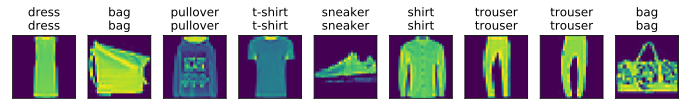

In [31]:
for X, y in test_iter:
    break

true_labels = utils.get_fashion_mnist_labels(y.asnumpy())
pred_labels = utils.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

utils.show_fashion_mnist(X[0:9], titles[0:9])

### Exercise
1. If we implement softmax according to its maths definition, what will happen? (Tip: try to calculate exp(50)

> Answer: exp(50) is very big, if we implement softmax based on its maths defintion, our pragram will throw error or get unstable calculation results.

2. Function `cross_entropy` implements according to its maths definition. Is there anything with this implement?(Tip: thinking about the domain of a logarithmic function)

> Answer: The domain of logarithmic function is from 0 to infinity. So we must keep all feature positive and keeping them between 0-1 is the best choice. 

3. What methods can you think of to solve the above problems?

> Answer: None, How stupid I am!